Now only going to try using one of the constructers at a time 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, auc
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.utils import to_categorical
tf.test.is_gpu_available()
os.chdir('/data/swamyvs/pacbio_testing/')

/data/swamyvs/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
class SimpleDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size,which_constr, one_label, zero_label, y_format='tf'):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        Y_vec=np.asarray(X_df_labeled['target_label'])
        
        selected_cases=['all', which_constr, f'{which_constr}-pacbio']
        sel_bool=labs['intersection_case'].isin(selected_cases)
        X_data=X_data[sel_bool]
        labs=labs[sel_bool]
        Y_vec=Y_vec[sel_bool]
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        
        X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
        self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                                  random_state=42,stratify=Y_train_labs['target_label'])

        if y_format == 'tf':
            self.Y_val=to_categorical(Y_val_labs['target_label'])
            self.Y_train=to_categorical(Y_train_labs['target_label'])
            self.Y_test=to_categorical(Y_test_labs['target_label'])
        else:
            self.Y_val=np.asarray(Y_val_labs['target_label'])
            self.Y_train=np.asarray(Y_train_labs['target_label'])
            self.Y_test=np.asarray(Y_test_labs['target_label'])
            
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']] 
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]
            
        self.y_format=y_format
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')


def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    AUC = auc(rec, pre)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()  
def skl_model_results(obj, model):
    X_train=obj.X_train
    Y_train=obj.Y_train
    X_test=obj.X_test
    Y_test=obj.Y_test
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)
    return(model)


In [3]:
dat_st=dat=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'stringtie',
                  'transcript',
                  'not_transcript',
                  'sk'
                 )
dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'stringtie',
                  'transcript',
                  'not_transcript',
                  'tf'
                 )




In [4]:
[sum(dat_st.Y_train == 1) / sum(dat_st.Y_train == 0),sum(dat_st.Y_test == 1) / sum(dat_st.Y_test == 0),sum(dat_st.Y_val == 1) / sum(dat_st.Y_val == 0)]

[0.9314733418929177, 0.931473984105563, 0.931473984105563]

In [5]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)
rf_model.fit(dat_st.X_train, dat_st.Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

confusion matrix


       0      1
0  19209   7467
1   6340  18508


classification report


              precision    recall  f1-score   support

           0       0.75      0.72      0.74     26676
           1       0.71      0.74      0.73     24848

    accuracy                           0.73     51524
   macro avg       0.73      0.73      0.73     51524
weighted avg       0.73      0.73      0.73     51524



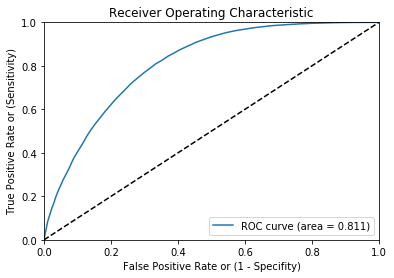

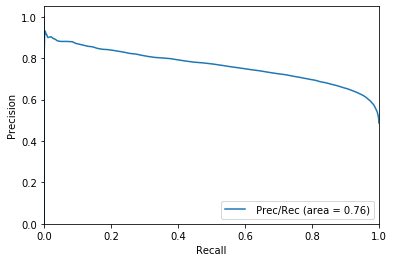

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [6]:
skl_model_results(dat, rf_model)

In [9]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
MAX_TRAIN_SIZE=len(dat_tf.X_train) +1
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def train_dense_model(obj):
    model=keras.Sequential()
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(200,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(10,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=200, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)
def run_all(model, data, plot_title):
    history, model = model(data)
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    pred=[p[1] for p in  model.predict(data.X_test)]
    pred_class = np.int64([p > .5 for p in pred])
    true_class=[i[1] for i in data.Y_test]
    
    fpr, tpr, thresholds=roc_curve(true_class, pred)
    AUC=roc_auc_score(true_class, pred)
    # Plot ROC curve
    plt.subplot(2,3,4)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
   
    pre, rec, thresholds = precision_recall_curve(true_class, pred)
    AUC = auc(rec, pre)
    plt.subplot(2,3,5)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall plot')
    plt.legend(loc="lower right")
    
    
    plt.suptitle(plot_title)
    plt.show()
    labs=[data.zero_label, data.one_label] 
    print(pd.DataFrame(confusion_matrix(true_class, pred_class), index=labs, columns=labs))
    print(classification_report(pred_class,true_class))
    return history, model 





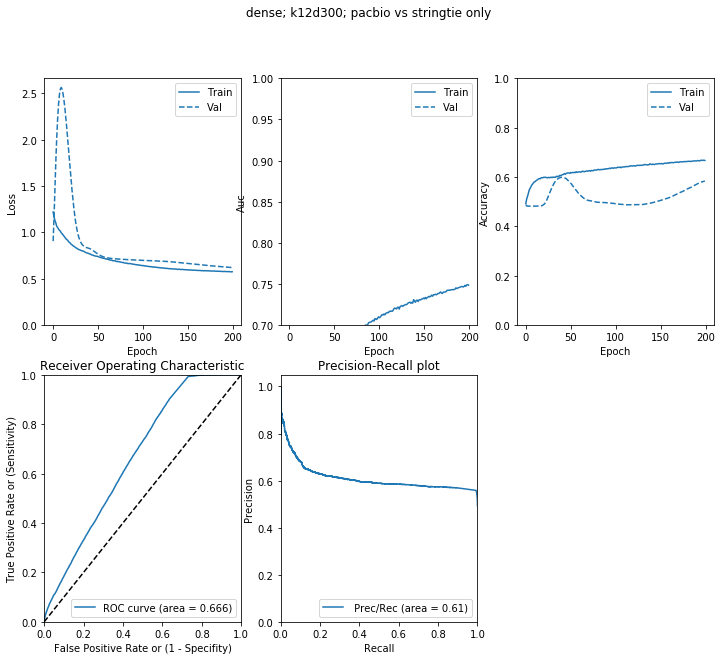

                not_transcript  transcript
not_transcript           19625        7051
transcript               14518       10330
              precision    recall  f1-score   support

           0       0.74      0.57      0.65     34143
           1       0.42      0.59      0.49     17381

    accuracy                           0.58     51524
   macro avg       0.58      0.58      0.57     51524
weighted avg       0.63      0.58      0.59     51524



In [10]:
dense_hist, dense_model=run_all(train_dense_model, dat_tf, 'dense; k12d300; pacbio vs stringtie only')

In [19]:
class RnnDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size,block_size,which_constr, one_label, zero_label):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        
        assert X_data.shape[1] % block_size == 0
        block_dim=int(X_data.shape[1] / block_size)
        X_data=np.asarray( [vec.reshape(block_size, block_dim) for vec in X_data])
        Y_vec=np.asarray(X_df_labeled['target_label'])
        
        selected_cases=['all', which_constr, f'{which_constr}-pacbio']
        sel_bool=labs['intersection_case'].isin(selected_cases)
        X_data=X_data[sel_bool]
        labs=labs[sel_bool]
        Y_vec=Y_vec[sel_bool]
        
        
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        
        X_train, self.X_test, Y_train_labs, Y_test_labs= train_test_split(X_data,labs,test_size=.16, random_state=42, stratify=Y_vec)
        self.X_train, self.X_val, Y_train_labs, Y_val_labs=train_test_split(X_train,Y_train_labs,test_size=.23809, 
                                                                                  random_state=42,stratify=Y_train_labs['target_label'])

        self.Y_val=to_categorical(Y_val_labs['target_label'])
        self.Y_train=to_categorical(Y_train_labs['target_label'])
        self.Y_test=to_categorical(Y_test_labs['target_label'])     
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']] 
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')
        
        
        
        
def LSTM_dense_model(obj, batch_n=128, nepochs=300):
    NUM_UNITS=150
    MAX_TRAIN_SIZE=int(obj.X_train.shape[0] / batch_n)
    DIM=obj.X_train.shape[1:]
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=DIM))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=NUM_UNITS)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=nepochs, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)

In [ ]:
rnn_dat_st=RnnDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                   30,
                  'stringtie',
                  'transcript',
                  'not_transcript'
                 )

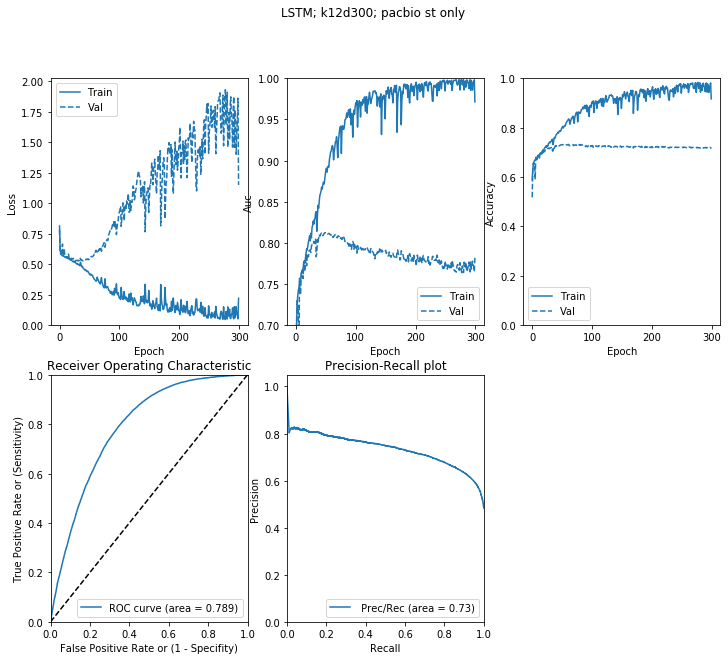

                not_transcript  transcript
not_transcript           19315        7361
transcript                7182       17666
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     26497
           1       0.71      0.71      0.71     25027

    accuracy                           0.72     51524
   macro avg       0.72      0.72      0.72     51524
weighted avg       0.72      0.72      0.72     51524



In [21]:
rnn_st_hist, rnn_st_model = run_all(LSTM_dense_model, rnn_dat_st, 'LSTM; k12d300; pacbio st only ')

In [25]:
dat_sp

stringtie           26676
stringtie-pacbio    14699
all                 10149
Name: intersection_case, dtype: int64

In [26]:
dat_sp=dat=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'scallop',
                  'transcript',
                  'not_transcript',
                  'sk'
                 )
dat_tf_so=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'scallop',
                  'transcript',
                  'not_transcript',
                  'tf'
                 )

In [29]:
rf_sp_model=RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)
rf_sp_model.fit(dat_sp.X_train, dat_sp.Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

confusion matrix


       0      1
0  25947   4656
1   6771  10275


classification report


              precision    recall  f1-score   support

           0       0.79      0.85      0.82     30603
           1       0.69      0.60      0.64     17046

    accuracy                           0.76     47649
   macro avg       0.74      0.73      0.73     47649
weighted avg       0.76      0.76      0.76     47649



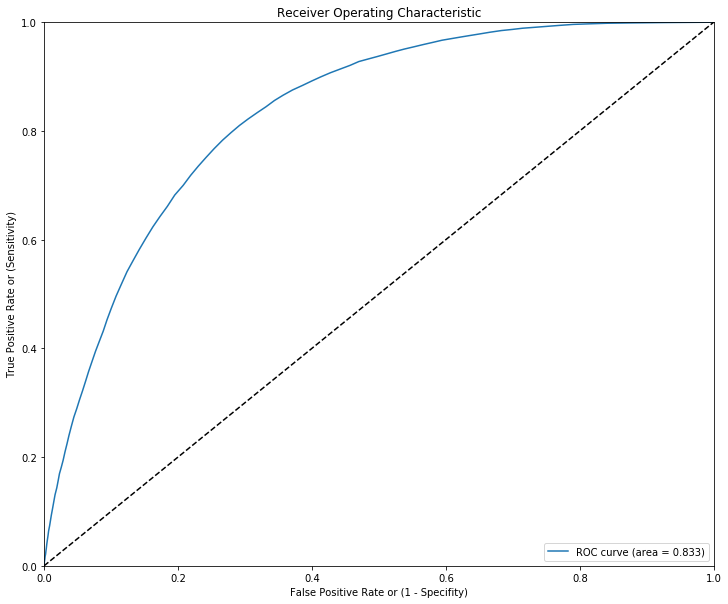

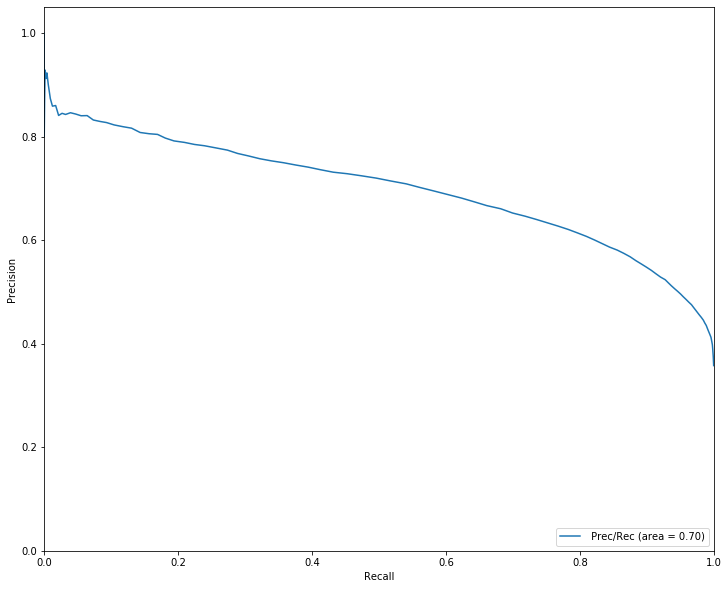

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [30]:
skl_model_results(dat_sp, rf_sp_model)

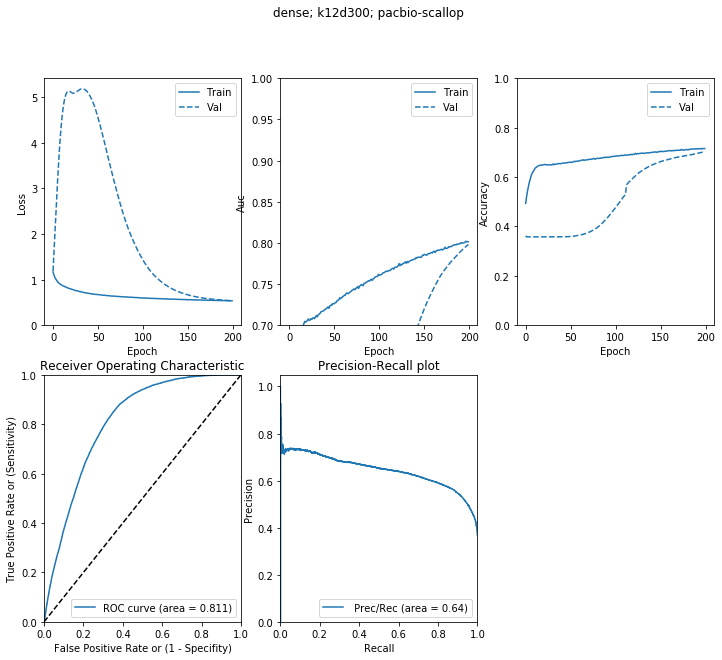

                not_transcript  transcript
not_transcript           18427       12176
transcript                1891       15155
              precision    recall  f1-score   support

           0       0.60      0.91      0.72     20318
           1       0.89      0.55      0.68     27331

    accuracy                           0.70     47649
   macro avg       0.75      0.73      0.70     47649
weighted avg       0.77      0.70      0.70     47649



In [32]:
dense_sp_hist, dense_sp_model=run_all(train_dense_model, dat_tf_so, 'dense; k12d300; pacbio-scallop')

In [33]:
rnn_dat_sp=RnnDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                   30,
                  'stringtie',
                  'transcript',
                  'not_transcript'
                 )

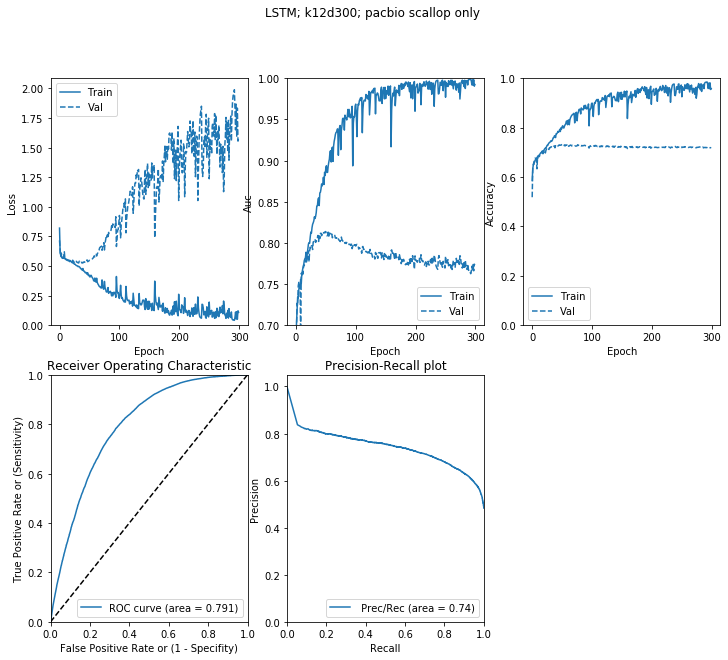

                not_transcript  transcript
not_transcript           19245        7431
transcript                6904       17944
              precision    recall  f1-score   support

           0       0.72      0.74      0.73     26149
           1       0.72      0.71      0.71     25375

    accuracy                           0.72     51524
   macro avg       0.72      0.72      0.72     51524
weighted avg       0.72      0.72      0.72     51524



In [34]:
rnn_sp_hist, rnn_sp_model = run_all(LSTM_dense_model, rnn_dat_sp, 'LSTM; k12d300; pacbio scallop only ')

In [36]:
def extract_intersection_cases(model, data):
    pred=np.asarray([p[1] for p in  model.predict(data.X_test)])
    pred_class = np.int64([p > .5 for p in pred])
    true_class=np.asarray([i[1] for i in data.Y_test])
    pred_cor= true_class == pred_class
    pred_fal= true_class != pred_class
    pred_true_probs=pred[pred_cor]
    pred_true_labels = data.Y_test_labs['intersection_case'][pred_cor]
    pred_false_probs = pred[pred_fal]
    pred_false_labels = data.Y_test_labs['intersection_case'][pred_fal]
    pred_true_txid = data.Y_test_labs['transcript_id'][pred_cor]
    pred_false_txid = data.Y_test_labs['transcript_id'][pred_fal]
    return pd.DataFrame({'probs':pred_true_probs, 'labs':pred_true_labels, 'transcript_id': pred_true_txid}, index=None), \
            pd.DataFrame({'probs':pred_false_probs, 'labs':pred_false_labels, 'transcript_id': pred_false_txid}, index=None)

right, wrong = extract_intersection_cases(rnn_st_model, rnn_dat_sp)

In [43]:
positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
true_called_false = wrong[ wrong.labs.isin(positive_cases) ]
false_called_true = wrong[ ~wrong.labs.isin(positive_cases) ]

In [44]:
false_called_true.probs.describe()

count    7431.000000
mean        0.928662
std         0.122330
min         0.500069
25%         0.918225
50%         0.992124
75%         0.999693
max         1.000000
Name: probs, dtype: float64

In [42]:
true_called_false.probs.describe()

count    6.904000e+03
mean     8.800466e-02
std      1.315443e-01
min      1.924804e-21
25%      8.602743e-04
50%      1.696304e-02
75%      1.264994e-01
max      4.994527e-01
Name: probs, dtype: float64

In [47]:
true_called_true = right[ right.labs.isin(positive_cases) ]
false_called_false = right[ ~right.labs.isin(positive_cases) ]

In [49]:
true_called_true.probs.describe()

count    17944.000000
mean         0.958108
std          0.095815
min          0.500188
25%          0.978525
50%          0.998586
75%          0.999971
max          1.000000
Name: probs, dtype: float64